# Data Sanity Check

In [ ]:
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
import torch # Added for un-normalization in visualization

# Add project root to path to allow importing from src
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_management import (
    load_data,
    get_transforms
)
from src.data_analysis import (
    get_data_summary,
    verify_images,
    analyze_pneumonia_subtypes,
    check_for_data_leakage
)

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

print("Setup complete. Downloading data...")
dataset_path = load_data()
print(f"\nDataset path: {dataset_path}")

## 1. Data Loading & Structure / Class Imbalance

First, we confirm that the data is loaded correctly and count the number of images in each split (train, validation, test) and for each class (Normal, Pneumonia). This gives us an immediate look at the class balance.

Dataset Summary:
       NORMAL  PNEUMONIA  TOTAL
train    1341       3875   5216
val         8          8     16
test      234        390    624
TOTAL    1583       4273   5856


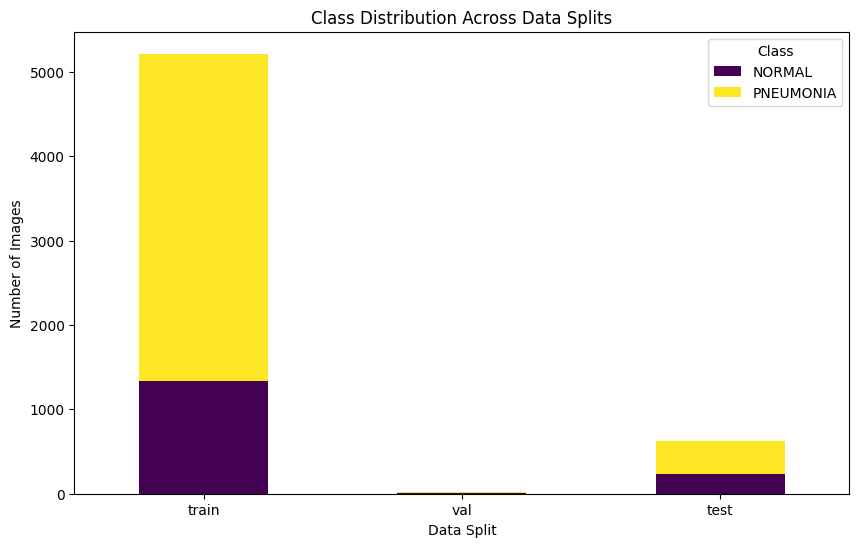

In [14]:
summary_df = get_data_summary(dataset_path)
print("Dataset Summary:")
print(summary_df)

# Plotting the class distribution
summary_df_to_plot = summary_df.drop('TOTAL').drop('TOTAL', axis=1)
ax = summary_df_to_plot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Class Distribution Across Data Splits')
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.show()

## 2. Image Content & Format

We need to ensure the image files are valid and understand their properties, like dimensions and color format. We'll check a random sample of images.

In [15]:
image_verification_results, sample_paths = verify_images(dataset_path, num_samples_to_check=10000)

print(f"Corrupted files found: {len(image_verification_results['corrupted_files'])}")
if image_verification_results['corrupted_files']:
    print(image_verification_results['corrupted_files'])

print(f"\nColor mode counts (from a sample of {image_verification_results['total_checked']} images):")
for mode, count in image_verification_results['modes'].items():
    print(f"- {mode}: {count} images")

print(f"\nUnique dimensions found: {len(image_verification_results['dimensions'])} and a few examples are: {list(image_verification_results['dimensions'])[:5]}")

Corrupted files found: 0

Color mode counts (from a sample of 5856 images):
- RGB: 283 images
- L: 5573 images

Unique dimensions found: 4803 and a few examples are: [(976, 544), (848, 624), (1994, 1839), (1416, 816), (1454, 1071)]


### Image Dimension Distribution

A histogram of image widths and heights gives us a better sense of the variation in the dataset. This is crucial for deciding on a target size for resizing during preprocessing.

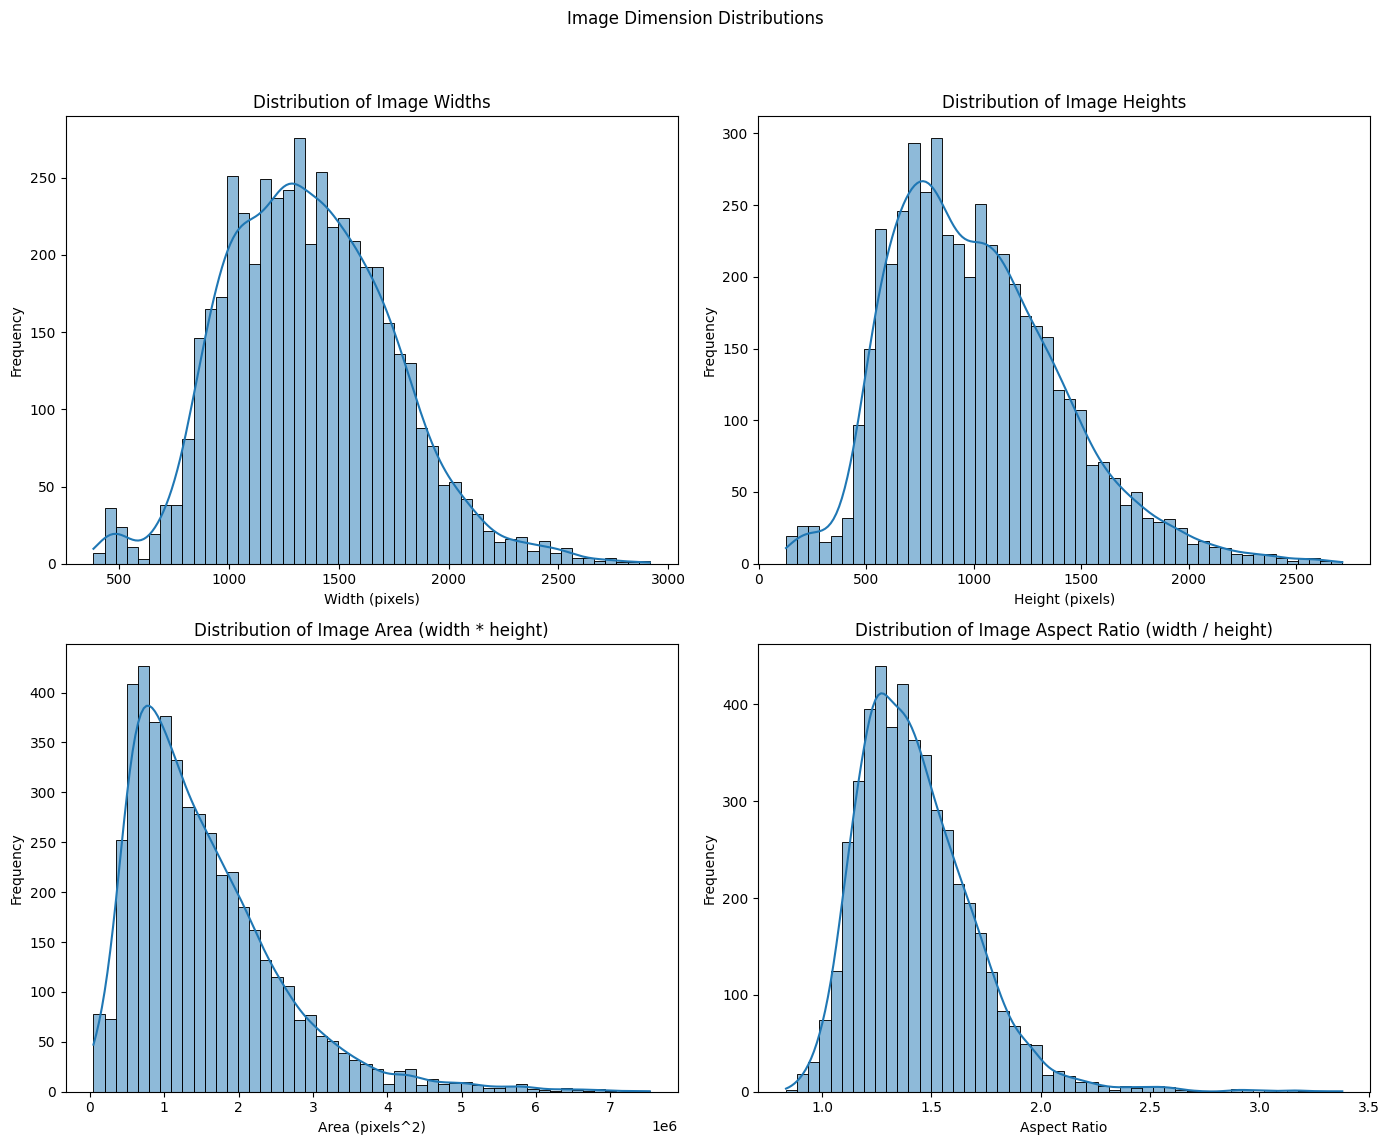

In [16]:
# Extract dimensions into a DataFrame for easier plotting
dimensions = image_verification_results['dimensions']
dimensions_df = pd.DataFrame(list(dimensions), columns=['width', 'height'])
dimensions_df['area'] = dimensions_df['width'] * dimensions_df['height']
dimensions_df['aspect_ratio'] = dimensions_df['width'] / dimensions_df['height']


# Plot histograms for width and height
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.histplot(dimensions_df['width'], bins=50, kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(dimensions_df['height'], bins=50, kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(dimensions_df['area'], bins=50, kde=True)
plt.title('Distribution of Image Area (width * height)')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(dimensions_df['aspect_ratio'], bins=50, kde=True)
plt.title('Distribution of Image Aspect Ratio (width / height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.suptitle('Image Dimension Distributions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

### Visualize Sample Images

Displaying random sample of images from the dataset...


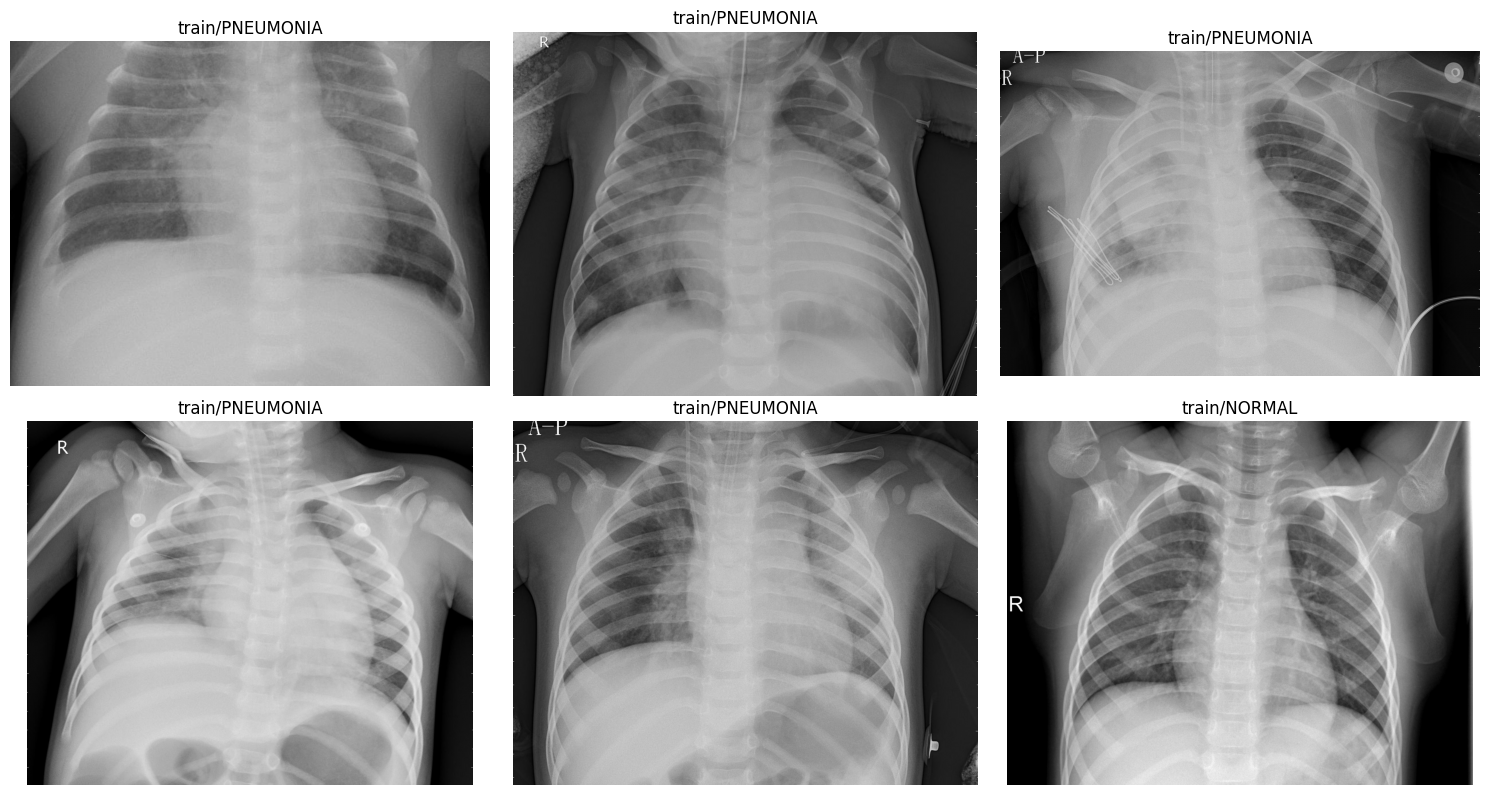

In [17]:
def show_sample_images(image_paths, num_to_show=6):
    if not image_paths:
        print("No images to display.")
        return
    
    plt.figure(figsize=(15, 8))
    num_to_show = min(len(image_paths), num_to_show)
    for i, img_path in enumerate(image_paths[:num_to_show]):
        plt.subplot(2, 3, i + 1)
        try:
            with Image.open(img_path) as img:
                plt.imshow(img, cmap='gray')
                class_name = img_path.parent.name
                split_name = img_path.parent.parent.name
                plt.title(f"{split_name}/{class_name}")
                plt.axis('off')
        except Exception as e:
            print(f"Could not load {img_path}: {e}")
    plt.tight_layout()
    plt.show()

print("Displaying random sample of images from the dataset...")
show_sample_images(sample_paths)

## 3. Label & Anomaly Verification

### Pneumonia Subtypes (Viral vs. Bacterial)
This helps us decide if a 3-class classification problem is feasible or if we should stick to a binary (Normal vs. Pneumonia) problem.

In [18]:
subtype_df, unknown_paths = analyze_pneumonia_subtypes(dataset_path)
print("Pneumonia Subtype Summary:")
print(subtype_df)

Pneumonia Subtype Summary:
       bacteria  virus  TOTAL
train      2530   1345   3875
val           8      0      8
test        242    148    390
TOTAL      2780   1493   4273


In [19]:
if unknown_paths:
    print(f"\nFound {len(unknown_paths)} images with unknown pneumonia subtype:")
    for path in unknown_paths:
        print(path.name)
    
    print("\nDisplaying unknown subtype images...")
    show_sample_images(unknown_paths)
else:
    print("\nNo unknown pneumonia subtypes found.")


No unknown pneumonia subtypes found.


### Check for Data Leakage
A critical step. We verify that no identical images exist across the `train`, `val`, and `test` sets. Even one leak can invalidate our test results.

In [20]:
leakage_results = check_for_data_leakage(dataset_path)
print("\nData Leakage Check Results:")
print(f"- Duplicates between train and val sets: {leakage_results['train_val']}")
print(f"- Duplicates between train and test sets: {leakage_results['train_test']}")
print(f"- Duplicates between val and test sets: {leakage_results['val_test']}")


Data Leakage Check Results:
- Duplicates between train and val sets: 0
- Duplicates between train and test sets: 0
- Duplicates between val and test sets: 0


## 4. Distribution & Preprocessing

### Pixel Intensity Distribution

We look at the pixel value histograms for a few sample images. This helps us understand if we need specific normalization techniques like contrast adjustment, in addition to standard scaling.

In [21]:
def plot_pixel_histograms(image_paths, num_to_show=6):
    if not image_paths:
        print("No images to display for this mode.")
        return
        
    plt.figure(figsize=(15, 8))
    num_to_show = min(len(image_paths), num_to_show)
    for i, img_path in enumerate(image_paths[:num_to_show]):
        plt.subplot(2, 3, i + 1)
        try:
            with Image.open(img_path) as img:
                img_gray = img.convert('L')
                pixel_values = np.array(img_gray).flatten()
                sns.histplot(pixel_values, bins=256, kde=False)
                class_name = img_path.parent.name
                plt.title(f'Hist for a {class_name} Image')
        except Exception as e:
            print(f"Could not process {img_path}: {e}")
    plt.tight_layout()
    plt.show()

#### RGB Image Histograms

Displaying pixel histograms for a random sample of 'RGB' images...


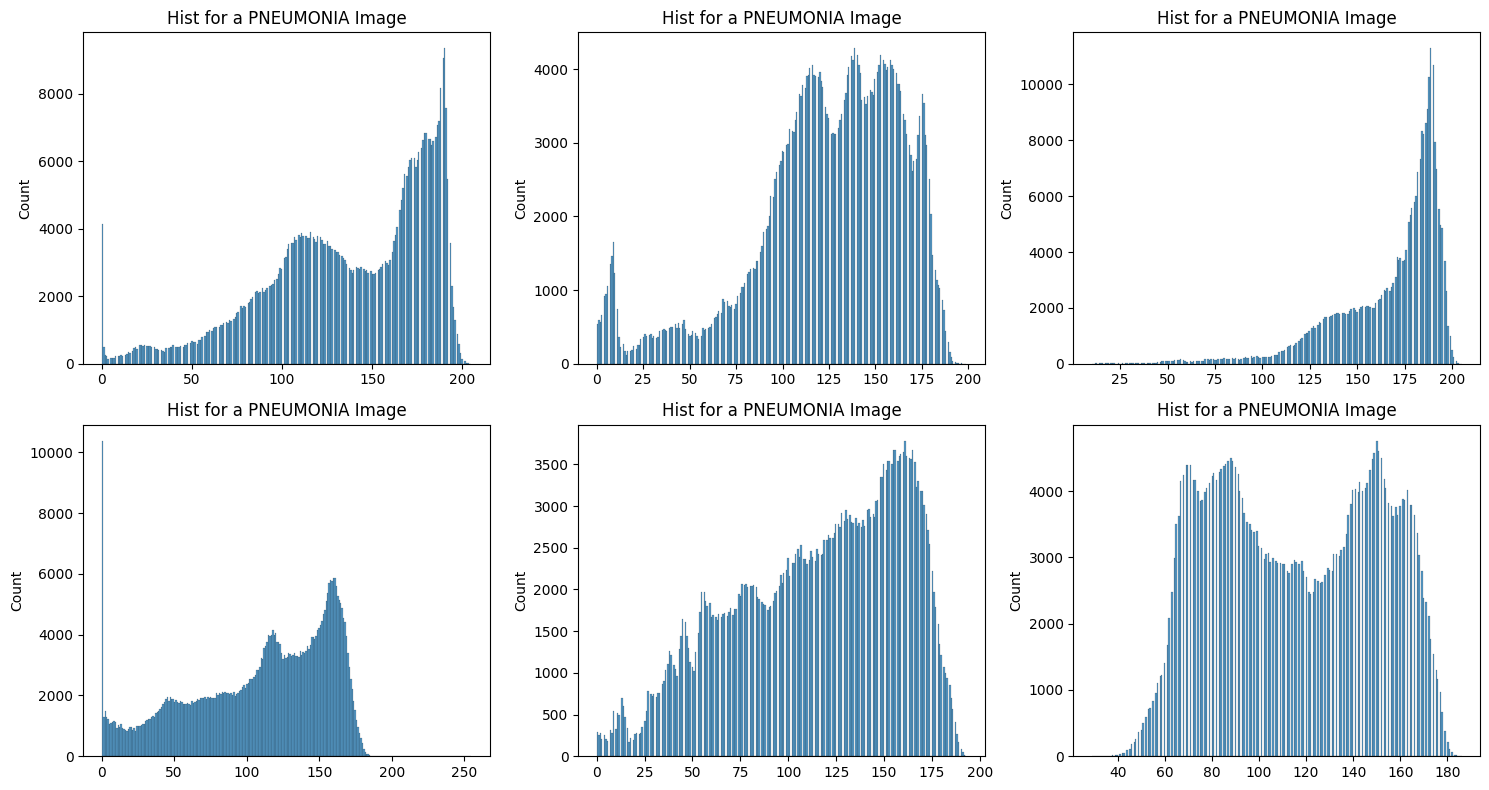

In [22]:
print("Displaying pixel histograms for a random sample of 'RGB' images...")
plot_pixel_histograms(image_verification_results['paths_by_mode']['RGB'])

#### Grayscale (L) Image Histograms

Displaying pixel histograms for a random sample of 'L' images...


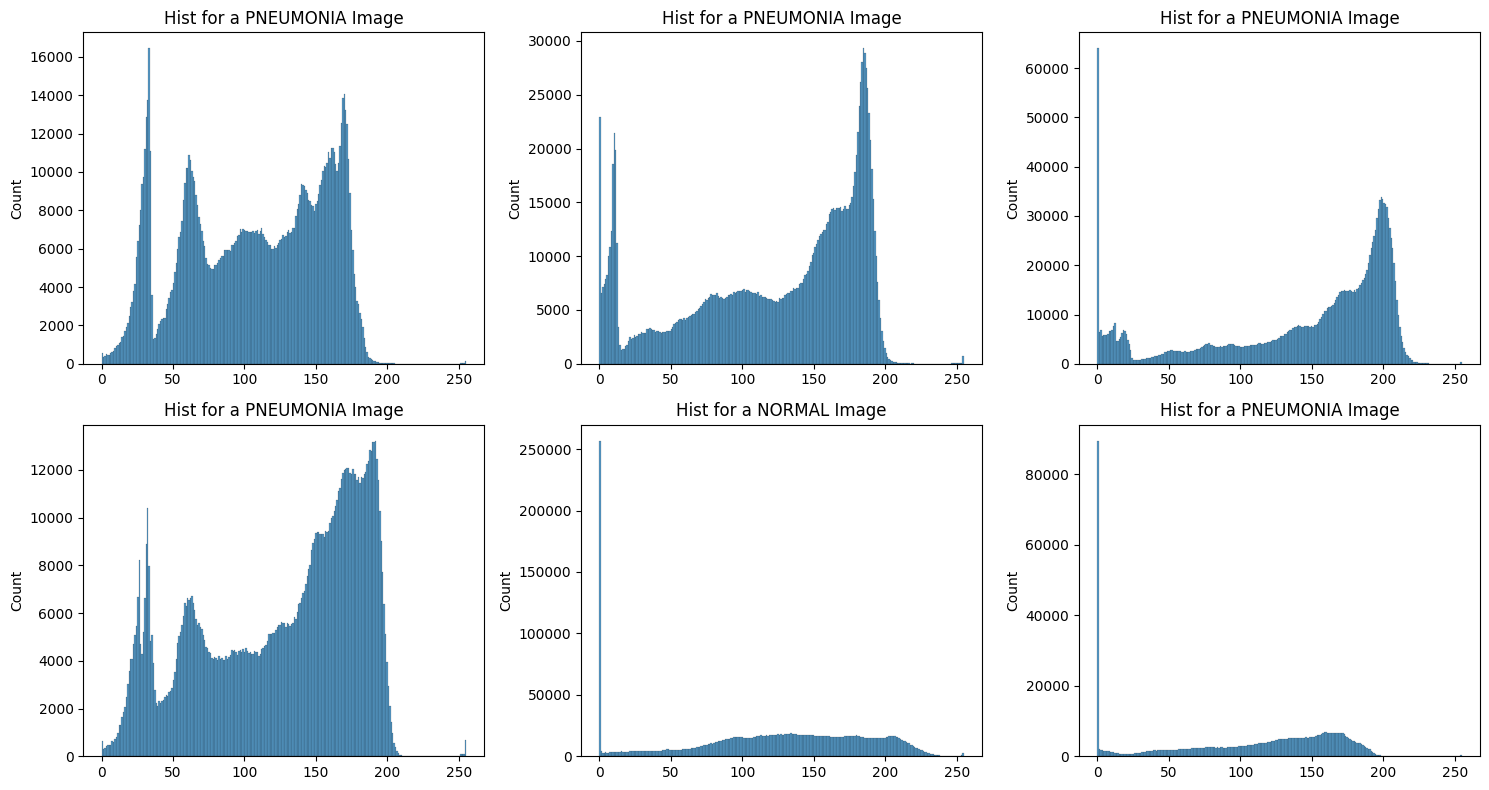

In [23]:
print("Displaying pixel histograms for a random sample of 'L' images...")
plot_pixel_histograms(image_verification_results['paths_by_mode']['L'])

## 5. Preprocessing for CNN Input

Before feeding images into a CNN like ResNet, they must all be the same size. We'll use the 'Resize and Pad' strategy we defined. Here, we visualize the effect of our `preprocess_image` function on a few sample images from the dataset.

Displaying 4 preprocessed examples...


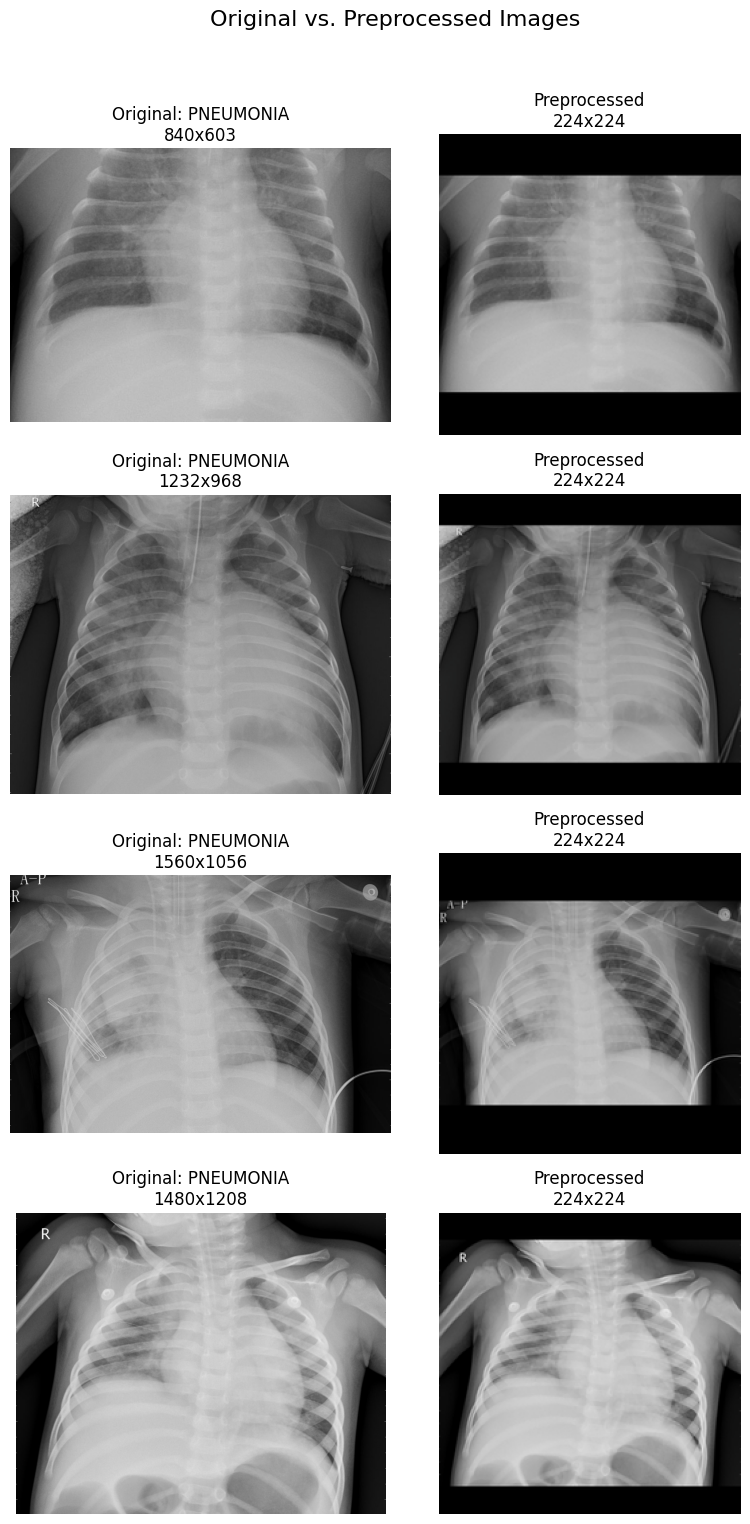

In [24]:
# Define the target size for the neural network input
target_size = (224, 224)
preprocess_pipeline = get_transforms()

num_to_show = 4
example_paths = []
if 'sample_paths' in locals() and len(sample_paths) >= num_to_show:
    example_paths = sample_paths[:num_to_show]
else:
    # Fallback if sample_paths is not available or too short
    print('`sample_paths` not available or too short, getting new samples.')
    train_path = dataset_path / 'train'
    normal_path = train_path / 'NORMAL'
    pneumonia_path = train_path / 'PNEUMONIA'
    if normal_path.is_dir():
        example_paths.extend(list(normal_path.glob('*.jpeg'))[:2])
    if pneumonia_path.is_dir():
        example_paths.extend(list(pneumonia_path.glob('*.jpeg'))[:2])

if example_paths:
    print(f"Displaying {len(example_paths)} preprocessed examples...")
    num_examples = len(example_paths)
    fig, axes = plt.subplots(num_examples, 2, figsize=(8, 4 * num_examples))
    fig.suptitle('Original vs. Preprocessed Images', fontsize=16)

    # ImageNet statistics for un-normalization for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, img_path in enumerate(example_paths):
        original_img_pil = Image.open(img_path).convert('RGB')
        
        # Handle the case where axes might be 1D if num_examples is 1
        ax1 = axes[i, 0] if num_examples > 1 else axes[0]
        ax2 = axes[i, 1] if num_examples > 1 else axes[1]

        ax1.imshow(original_img_pil)
        ax1.set_title(f"Original: {img_path.parent.name}\n{original_img_pil.size[0]}x{original_img_pil.size[1]}")
        ax1.axis('off')

        preprocessed_tensor = preprocess_pipeline(original_img_pil)
        
        # Convert preprocessed tensor back to image format for display
        unnormalized_img = preprocessed_tensor * std + mean
        preprocessed_img_np = unnormalized_img.permute(1, 2, 0).numpy()        
        preprocessed_img_np = preprocessed_img_np.clip(0, 1)

        ax2.imshow(preprocessed_img_np)
        ax2.set_title(f"Preprocessed\n{target_size[0]}x{target_size[1]}")
        ax2.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()
else:
    print('Could not find any images to display.')